<h1>HOKI Crash Course Tutorial by Ryota Inagaki for Moving Universe Lab </h1>
<p>Based on <a href=https://heloises.github.io/hoki/index.html>Heloise Stevance's Hoki documentation and recipies</a>
<p>Welcome to the tutorial! Through this crash course, we will be learning how to use Hoki, a Python interface for BPASS (Binary Population and Spectral Synthesis) models. BPASS, an amalgamation of data products representing HR Diagrams, CMDs, transient rates, and other properties of stellar clusters, is a powerful tool accounting for binary stellar populations. This excellent modeling is complemented with the usability of Hoki and IPython. With the combination of the two tool and this tutorial, you will be a step closer to making groundbreaking discoveries!</p>
<p> Feel free to add your own features to this notebook. I strongly encourage practicing on this notebook rather than clicking through it. </p>
<p>Notes on setup: </p>
<ol>
<li> Go on git hub and download the latest release of Hoki</li>
    <li> Make path to the Hoki directory a part of the PATH environment variable </li>
    <li> Download some or all of the BPASS packages from <a href=https://drive.google.com/drive/folders/1FvwVO3bBiswoMYsBueDrAhfMKs2By0r>this Google Drive folder</a>. Download the bpass-v2.2-newmodels folder, which are needed for input_bpass files to work in some of our models. Please unzip the files.</li>
</ol>
<b>Important: For the best experience, please run the cells in order!!</b>

In [1]:
#Be sure that the notebook is using the astroconda kernel before running this.
import hoki
import pickle
from hoki.load import unpickle
from hoki import load, age_utils
from hoki.age_utils import AgeWizard
from hoki.cmd import CMD
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# This is in preparation for our tutorial on CMD's, which are dependent on access to
# to the stellar models in bpass-v2.2-newmodels.
#Thus we change the settings.yaml folder in Hoki such that model_path (path to the stellar models used by the CMD diagram constructor)
#is set to the absolute path to the bpass-v2.2.-newmodels directory.
set_models_path(path='/g/lu/scratch/ryotainagaki/BPASS/bpass-v2.2-newmodels')

<h2>How to understand file names</h2>
<p>The folders are usually named using the following system:
    BPASSv2.2.1_[sin OR bin]-model <p>
    <p>Files are usually named as follows: [output-type]-[sin OR bin]-model-.z["metallicity"].dat</p>
    <p>Notes:</p>
    <ol>
    <li> <b>Each file represents a single aged stellar cluster with 10^6 solar mass </b></li>
    <li><b>The discrete times at which properties of the stellar cluster are taken represent time bins. For ages 10^(6.1+0.1*x) years (where x is a whole number less than 50) the time bin width is 10^(6.15+0.1*x)-(10^(6.05+x)). The width of the 10^6 year time bin is 10^6.05. </b>
    
<li> If ["metallicity"] is equal to an integer x such as 020, that means cluster metallicity=x/1000. Otherwise if [metallicity] is of the form "emx" that means metallicity is 10^-x for the star cluster </li>
<li>Output types are phenomena such as supernova, hrs, spectra.</li>
<li>Model corresponds to an the Initial Mass Function whose parameters are outlined such that the IMF matches the mathematical form of the IMF integral equation below.
<li>Alpha 1 stands for the slope of the IMF from 0.1 to $M_{1}$. Alpha 2 stands for the slope of the IMF from $M_{1}$ to Maximum stellar mass </li>
</ol>
<img src="SnipBPASSIMF.PNG" width="800" height="400">
<p>Mathematical form of the IMF used for BPASS Source: (Elridge et. al 2017)</p>
<img src="Alphatables.PNG" width="400" height="200">
<p>The list of models and respective, IMF-defining quantities. The variables in the table are the same as and represent the same quantities as the variables in the figure above the table. (Source: Stanway et al 2018) </p>
<h2>Onto the coding</h2>
<p> To convert one of the BPASS model output files into Pandas DataFrames, use the following format: load.model_output('path to desired model output file') </p>


<h2>CMD and HR Diagrams </h2>
<p>For this lesson, we will try to create instances of HOKI's objects, the most important of which are the HRDiagram object, the CMD object, and the AgeWizard object </p> 
<p>The CMD object is created with the input of the String path to an input file in one of the BPASS folders.</p>
<p>A CMD diagram also needs to be described in terms of the colors-- here the difference of magnitudes of starlight fluxes that are caught by different filters-- and magnitudes-- the magnitude of the flux that is caught by one photometric filter.
    Thus CMD.make takes in one mag_filter (a string) and two color filters, which are in one Python List</p>
    <p>For more information regarding which filters are available, please check the manual. For this example I will be using the V and R filters from the Johnson-Cousins filters.</p>

/g/lu/scratch/ryotainagaki/hoki/hoki/cmd.py:191: RuntimeWarning: divide by zero encountered in log10
  self._log_ages = np.concatenate((np.array([0]), np.log10(self._my_data[1,1:])))
/g/lu/scratch/ryotainagaki/hoki/hoki/cmd.py:207: RuntimeWarning: divide by zero encountered in log10
  self._log_ages = np.concatenate((np.array([0]), np.log10(self._my_data[1,1:])))


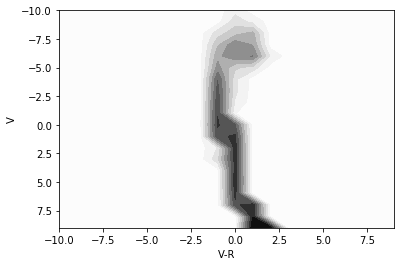

In [2]:
#First let's create a CMD. Constructor format CMD('path to input file')
#We also limit the colors and magnitudes that are graphed through col_lim and 
hokicmd=CMD('/g/lu/scratch/ryotainagaki/BPASS/bpass_v2.2.1_imf135all_100/input_bpass_z020_bin_imf135all_100', col_lim=[-10, 10], mag_lim=[-10, 10],res_el=1.0)
hokicmd.make(mag_filter='V', col_filters=['V', 'R'])
#Plot the CMD of the cluster at 10^7.4 years of age
hokicmd.plot(log_age=7.4)

<p>Let's pickle this CMD-- i.e. save the CMD object as a .pckl file so that it can be recovered in a different Jupyter Notebook. This saves us time that would be wasted from calling the CMD constructor, inputing the path to the same file, and waiting for Hoki to do its calculations. To do this, we use the open('path to file to which you want to save cmd', 'wb')
To convert a pickled CMD file to a CMD object use unpickle('path to pickled CMD file')
</p>


In [3]:
Storage=open('/u/ryotainagaki/Desktop/TutorialCMD.pckl', 'wb')
pickle.dump(hokicmd, Storage)
Storage.close()

<p>For HR Diagrams, we need to be given a BPASS Model output (in form of a .dat file) to create an HR Object.</p>
<p>hr_type is an extra parameter you need for loading an hr diagram that indicates whether the HR diagram will be a temperature vs luminosity diagram ('TL'), a temperature vs surface gravity diagram ('TG'), or a temperature vs temperature^4/surface gravity diagram ('TTG'). Note that L is in solar metallicities, T is in Kelvins, and G is in meters/second.</p>

In [4]:
hr=load.model_output('/g/lu/scratch/ryotainagaki/BPASS/BPASSv2.2.1_bin-imf135all_100/hrs-bin-imf135all_100.z020.dat', hr_type='TL')

<p> But what is really inside the HR diagram object? Inside the HR diagaram object, there are 51 age bins (from log(age)=6.0 to log(age)=11.0) represented with high, medium, low, or all metallicities considered along with the 3 types of HR diagrams. Compounded with is the 100 row x 100 column grids (51 x 3 x 3 of them).</p>
<p>Details aside let's graph one HR diagram representing a cluster of age 10^7.7 years </p>

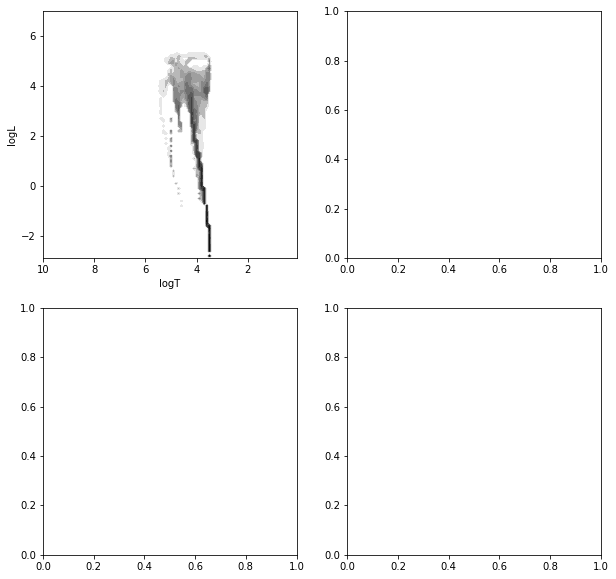

In [5]:
#To graph an HR diagram at a certain age (here at 10^7.7 years old)
f, a=plt.subplots(2, 2, figsize=(10, 10)) #This is to demonstrate the loc parameter that you can use to locate the HR Diagram
#Feel free to add more HR Diagrams in the currently blank subplots.
hr.plot(log_age=7.7, loc=a[0, 0])

<p> After plotting the HR Diagrams, you can add points of data from observational data if the x and y points are in the same units as points in the HR Diagram</p>
<p>However, for now, let's experiment with "stacking" HR diagrams to create an HR diagram/distribution for a given age range.</p>

The following attributes were updated: .all_stacked, .high_H_stacked, .medium_H_stacked, .low_H_stacked.
The following attributes were updated: .all_stacked, .high_H_stacked, .medium_H_stacked, .low_H_stacked.


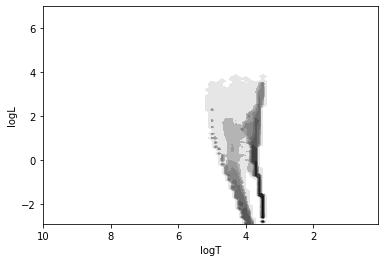

In [6]:
#First we stack the HR diagrams so that the hr plot is for the interval 10**9.5 years to 10**10.5 years
hr.stack(log_age_min=9.5, log_age_max=10.5)
hr.plot(age_range=[9.5, 10.5])

<h2> Age Wizard and HR Diagrams </h2>

<p>For this part, we will need some "observational data" to input into our AgeWizard constructor. Thus, create a few fake stars  or import from a .dat, csv, or excel file with real color-magnitude or luminosity-effective temperature data.
In any case, the obs_df (observational data-frame) that you create manually or import/load from an external file must have columns of equal length named 'name' (with the names/identifiers of the stars) and one of the following:<p>
  <li>  'logT' and 'logL' for HR diagrams, which stand for log (T_effective in Kelvin) and log (Luminosity of star in solar luminosities) respectively!</li>
  <li>  'mag' and 'col' for CMD Diagrams where mag and col are magnitude and color of stars in absolute magnitudes </li>

In [7]:
FakeCluster=pd.DataFrame.from_dict({'name':np.array(['A', 'B', 'C', 'D']),'logT':np.array([4.0, 4.7, 4.6, 4.1]), 'logL':np.array([3.0, 4.0, 4.5, 5.1])})

<p>Age Wizard Takes in the model HR Diagram file and the obs_df-- data frame with the names, logT values, and logL values of the stars</p>

In [8]:
AW=AgeWizard(obs_df=FakeCluster, model='/g/lu/scratch/ryotainagaki/BPASS/BPASSv2.2.1_bin-imf135all_100/hrs-bin-imf135all_100.z020.dat')

<p>To calculate and retrieve the probability distribution function of the age of the cluster (the stars you inputted as a whole), 
We use the command calculate_sample_pdf(return_df=True).pdf. We then inspect the probabilities of the star cluster being of log10(age)=6.0, 6.1,... 6.9 </p>

In [9]:
SampleDataSamplePDF=AW.calculate_sample_pdf(return_df=True).pdf

<p>Let's check out the first few rows of the Cluster Age PDF and find out what is the probability of the cluster being of a certain age. After that, let's plot the PDF of the cluster's age.</p>

In [10]:
SampleDataSamplePDF.head(10)

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000001
5    0.000004
6    0.000014
7    0.000041
8    0.000151
9    0.001381
Name: pdf, dtype: float64

Text(0.5, 1.0, 'Probability Distribution of Ryota Cluster Age')

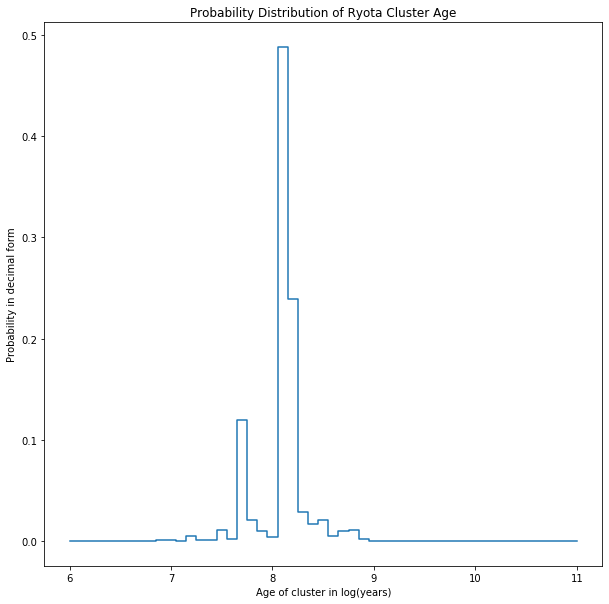

In [11]:
#Let's plot the PDf
plt.figure(figsize=(10, 10))
plt.step(hoki.BPASS_TIME_BINS, SampleDataSamplePDF, where='mid')
plt.xlabel('Age of cluster in log(years)')
plt.ylabel('Probability in decimal form')
plt.title('Probability Distribution of Ryota Cluster Age')

<p>We see that my imaginary star cluster would be about 10^8.1 years old if the AgeWizard could perfectly tell the age of the star cluster and assume that it is a single aged one. However, please keep in mind that the AgeWizard is not meant to straightforwardly tell the age of the star cluster: that would be left to statistical interpretation. </p>
<p>Now, let's access the probability distribution of the age of star B and learn how to view the probability distribution functions of ages of individual stars in a resolved cluster. </p>

Text(0.5, 1.0, "Probability Distribution of Star B's age")

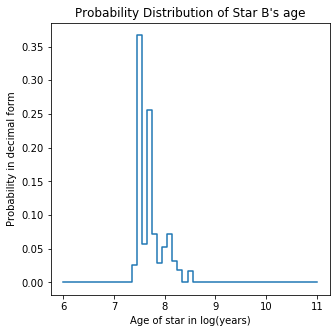

In [13]:
#To retrieve the PDF of an individual star's age
#First access pdfs. Note 'B' is the name of a star and column name. Once you access the PDF, it's like a table with 
#probability for each age bin (represented by row number) (Row number 0 is for 10^6.0 years Row number 51 is for 10^11.0 years)
AStarPDF=AW.pdfs['B']
plt.figure(figsize=(5, 5))
plt.step(hoki.BPASS_TIME_BINS, AStarPDF, where='mid')
plt.xlabel('Age of star in log(years)')
plt.ylabel('Probability in decimal form')
plt.title("Probability Distribution of Star B's age")

<h2>Let's try using a CMD based approach to finding an age of a stellar cluster</h2>
<p>When we are using a CMD to find the age of a cluster (here a different cluster than the one used earlier), we will keep in mind that the input of the AgeWizard is the observational data of stars' names, colors, and magnitudes contained in a Pandas DataFrame. We also need a CMD file with the metric of color and metric of magnitude being the same as that of the observational data with which the AgeWizard tries to find the most likely age and distribution of ages. </p>
<p>We will begin this tutorial by creating a synthetic cluster using PyPopStar. For those who are not familiar with the package, it is another stellar population synthesis program. Here, I create a cluster that is 10^7.5 years old in the SPISEA program. Note that the suggested most likely age outputted by HOKI will be different since BPASS models account for the physics of stellar evolution, namely the mass transfer mechanisms that help some stars last longer, that PyPopStar does not account for. </p>

In [15]:
#The following has absolute magnitudes of V and R filter light using a PyPopStar Cluster. If you have no idea as to what it is
#You can ignore this step for now
#ONLY RUN THIS CELL IF YOU HAVE SIPSEA (Hosek et al 2020)
from spisea import synthetic, reddening, evolution, atmospheres

#Set Up Isochrone
logAge=8.5
AKs=0.7
metallicity=0
evo_model=evolution.MISTv1()
atm_func=atmospheres.get_merged_atmosphere
red_law=reddening.RedLawDeMarchi16()
isochrone2=synthetic.IsochronePhot(logAge, AKs, 2000, metallicity=metallicity, red_law=red_law, evo_model=evo_model, atm_func=atm_func,filters=['ubv,V', 'ubv,R'], min_mass=1.0, recomp=True)

#Set up Cluster using Salpeter IMF account for multiplicity
import numpy as np
from spisea.imf import imf, multiplicity
cluster2=synthetic.ResolvedCluster(isochrone2, imf.IMFSalpeter1955(multiplicity=multiplicity.MultiplicityUnresolved()), 5000)
import math
VEFilterVals2=[]
RFilterVals2=[]
for x in cluster2.star_systems['m_ubv_V']:
    if not math.isnan(x):
        VEFilterVals2.append(x)


for y in cluster2.star_systems['m_ubv_R']:
    if not math.isnan(y):
        RFilterVals2.append(y)
        
#Account for Extinction via Extinction law and also for the distance from the star to observer
VExtreddening2=reddening.RedLawDeMarchi16().DeMarchi16(0.550, 0.7)
RExtreddeing2=reddening.RedLawDeMarchi16().DeMarchi16(0.635, 0.7)
VEFilterVals2=np.array(VEFilterVals2)-5*np.log10(2000)+5-VExtreddening2[0]
RFilterVals2=np.array(RFilterVals2)-5*np.log10(2000)+5-RExtreddeing2[0]



Isochrone generation took 19.363596 s.
Making photometry for isochrone: log(t) = 8.50  AKs = 0.70  dist = 2000
     Starting at:  2020-07-09 14:17:44.678872   Usually takes ~5 minutes
Starting filter: ubv,V   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   1.000 Msun  T =  5731 K  m_ubv_V = 20.73
M =   2.880 Msun  T = 10134 K  m_ubv_V = 15.63
M =   3.412 Msun  T =  3343 K  m_ubv_V = 14.19
M =   3.412 Msun  T = 26422 K  m_ubv_V = 12.56
M =   3.412 Msun  T = 195905 K  m_ubv_V = 18.90
Starting filter: ubv,R   Elapsed time: 1.75 seconds
Starting synthetic photometry
M =   1.000 Msun  T =  5731 K  m_ubv_R = 19.80
M =   2.880 Msun  T = 10134 K  m_ubv_R = 15.06
M =   3.412 Msun  T =  3343 K  m_ubv_R = 12.36
M =   3.412 Msun  T = 26422 K  m_ubv_R = 12.05
M =   3.412 Msun  T = 195905 K  m_ubv_R = 18.47
      Time taken: 3.48 seconds
Found 2942 stars out of mass range
Found 192 companions out of stellar mass range


In [16]:
#Create the data frames with the absolute magnitude and colors. Don't forget the 'names'
names=[]
for x in range(len(RFilterVals2)):
    names.append(str(x))
CMDCluster=pd.DataFrame.from_dict({'name':np.array(names),'mag': VEFilterVals2, 'col':(VEFilterVals2-RFilterVals2)})

In [17]:
#Create another AgeWizard Object
Agewiz2=AgeWizard(obs_df=CMDCluster, model='/u/ryotainagaki/Desktop/TutorialCMD.pckl') #IMPORTANT: Make sure the pickled CMD is a V, V-R CMD object

Text(0, 0.5, 'Probability in decimal form')

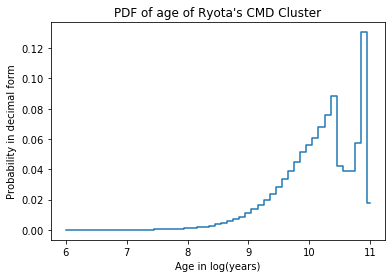

In [18]:
#Calculate the PDF of the culster's age
pdfcluster2=Agewiz2.calculate_sample_pdf(return_df=True).pdf
plt.step(hoki.BPASS_TIME_BINS, pdfcluster2, where='mid')
plt.title("PDF of age of Ryota's CMD Cluster")
plt.xlabel('Age in log(years)')
plt.ylabel('Probability in decimal form')

<p>We can access the data of the PDF as a series data structure. 
Note that the nth row stands for the 10^(6.0+0.1*n) years age of the cluster and the probability of the cluster being of that years of age</p>

In [ ]:
print(pdfcluster2.head(10))
print(pdfcluster2[3]) #Print the probability of the cluster being 10^6.3 years of age


<h3>Sources</h3>
    <li>HOKI by Heloise Stevance (Stevance et. al 2020)</li>
    <li>SPISEA by Matthew Hosek (Hosek et. al 2020) </li>